# A1 : Search Engine

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__, matplotlib.__version__

('1.25.2', '2.1.0', '3.7.2')

## 1. Data Loader

In [3]:
corpus = ["apple banana grape orange fruit", "banana apple orange grape fruit", "banana fruit orange grape apple",
          "dog cat mouse rabbit animal", "cat mouse rabbit animal dog", "cat dog animal rabbit mouse"]

# corpus = ('Code/Assignment/A1 - Search Engine/word-test.v1.txt')

# read the nltk dataset
# dataset >> some preparation for the dataset?


### tokenization

In [4]:
# tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'grape', 'orange', 'fruit'],
 ['banana', 'apple', 'orange', 'grape', 'fruit'],
 ['banana', 'fruit', 'orange', 'grape', 'apple'],
 ['dog', 'cat', 'mouse', 'rabbit', 'animal'],
 ['cat', 'mouse', 'rabbit', 'animal', 'dog'],
 ['cat', 'dog', 'animal', 'rabbit', 'mouse']]

### numericalization

In [5]:
# get unique word

# list comprehension for getting words
flatten = lambda l: [item for sublist in l for item in sublist]

# getting unique word and store as a list
vocab = list(set(flatten(corpus)))
vocab

['banana',
 'dog',
 'grape',
 'cat',
 'fruit',
 'rabbit',
 'mouse',
 'animal',
 'orange',
 'apple']

In [6]:
# add <UNK> to a dictionary vocab
vocab.append('<UNK>')

In [7]:
# numericalization: assign index to each word
word2index = {w:idx for idx, w in enumerate(vocab)}
word2index

{'banana': 0,
 'dog': 1,
 'grape': 2,
 'cat': 3,
 'fruit': 4,
 'rabbit': 5,
 'mouse': 6,
 'animal': 7,
 'orange': 8,
 'apple': 9,
 '<UNK>': 10}

In [8]:
# index2word
index2word = {k:v for v,k in word2index.items()}
index2word

{0: 'banana',
 1: 'dog',
 2: 'grape',
 3: 'cat',
 4: 'fruit',
 5: 'rabbit',
 6: 'mouse',
 7: 'animal',
 8: 'orange',
 9: 'apple',
 10: '<UNK>'}

## 2. Preparation for the train data

In [9]:
def random_batch(batch_size, corpus):

    # define a list for storing [center,outside] pair
    skipgrams = []

    # loop each word sequence
    for sent in corpus:
        
        for i in range(2, len(sent)-2):
            
            # assign center word
            center_word = word2index[sent[i]]
            
            # assign outside word=4 (ws = 2)
            outside_word = [word2index[sent[i-2]], word2index[sent[i-1]], word2index[sent[i+1]], word2index[sent[i+2]]]
            
            # for each of these two outside words, we gonna pair (center,outside) and append to a list
            for each_outside in outside_word:
                skipgrams.append([center_word, each_outside])
                
    # randomly select 2 pair among the data
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace = False)
    
    random_inputs = []
    random_labels = []
    
    for i in random_index:
        random_inputs.append([skipgrams[i][0]]) # center_word
        random_labels.append([skipgrams[i][1]]) # outside_word
        
    return np.array(random_inputs), np.array(random_labels)

#### testing

In [10]:
batch_size = 4
input_batch, label_batch = random_batch(4, corpus)
input_batch, label_batch

(array([[5],
        [7],
        [8],
        [6]]),
 array([[7],
        [1],
        [0],
        [7]]))

In [11]:
# for i in range(batch_size):
#     print(f"input = {index2word[input_batch[i]]} | label = {index2word[label_batch[i]]}")

## 3. Model

### 3.1 Skipgram model

In [12]:
class Skipgram (nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        
        # embedding for all: result as a vector for each 
        center_embed  = self.embedding_center(center_word)   # (batch_size, 1, emb_size)
        outside_embed = self.embedding_outside(outside_word) # (batch_size, 1, emb_size)
        all_embed     = self.embedding_outside(all_vocabs)   # (batch_size, voc_size, emb_size)
        
        # write the equation
        top_term = torch.exp(outside_embed.bmm(center_embed.transpose(1,2)).squeeze(2))
        # (batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (bacth_size, 1)
        
        lower_term = all_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        # (batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)
        # (batch_size, 1)
        
        loss = - torch.mean(torch.log(top_term / lower_term_sum))
        
        return loss

#### test the skipgram model

In [13]:
voc_size = len(vocab)
emb_size = 2
model = Skipgram(voc_size, emb_size)
model

Skipgram(
  (embedding_center): Embedding(11, 2)
  (embedding_outside): Embedding(11, 2)
)

In [14]:
batch_size = 2
x,y = random_batch(batch_size, corpus)

In [15]:
x,y

(array([[8],
        [8]]),
 array([[9],
        [9]]))

In [16]:
x.shape, y.shape

((2, 1), (2, 1))

In [17]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [18]:
# prepare for all_vocabs
def prepare_sequence (seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab)) #[batch_size, voc_size]

In [19]:
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab)) #[batch_size, voc_size]

In [20]:
all_vocabs

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [21]:
loss = model(input_tensor, label_tensor, all_vocabs)
loss

tensor(1.2251, grad_fn=<NegBackward0>)

### 3.2 Skip-gram negative sampling model

### 3.3 GloVe model

### 3.4 GloVe (Gensim) model

## 4.Train

In [22]:
voc_size       = len(vocab) # total vocab size
batch_size     = 2 # mini-batch size
embedding_size = 2

skipgram_model = Skipgram(voc_size, embedding_size)

skipgram_optimizer = optim.Adam(skipgram_model.parameters(), lr = 0.001)

In [23]:
# prepare for all_vocabs
def prepare_sequence (seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab)) #[batch_size, voc_size]

In [24]:
print(all_vocabs)
print(all_vocabs.shape)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
torch.Size([2, 11])


In [25]:
# for recording the training time for each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time # get the total taken timestamp
    elapsed_mins = int(elapsed_time / 60) # get the min
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60)) # get the sec
    return elapsed_mins, elapsed_secs

In [26]:
# training

import time

num_epochs = 5000

# loop for each epoch
for epoch in range(num_epochs):
    
    # record the start time
    start = time.time()
    
    # get the random training batch
    input_batch, output_batch = random_batch(batch_size, corpus)
    
    # to Tensor for embedding purpose
    input_tensor = torch.LongTensor(input_batch)   #[batch_size, 1]
    output_tensor = torch.LongTensor(output_batch) #[batch_size, 1]
    
    # train
    skipgram_optimizer.zero_grad()
    loss = skipgram_model(input_tensor, output_tensor, all_vocabs)
    
    # update loss
    loss.backward()
    skipgram_optimizer.step()
    
    # record the end time
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    if (epoch+1) % 1000 == 0:
        print(f"Epoch: {epoch+1} | loss: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | loss: 2.317922 | time: 0m 0s
Epoch: 2000 | loss: 1.923717 | time: 0m 0s
Epoch: 3000 | loss: 1.694552 | time: 0m 0s
Epoch: 4000 | loss: 1.823928 | time: 0m 0s
Epoch: 5000 | loss: 1.444429 | time: 0m 0s


## 5.Plotting the embeddings

In [27]:
# function to get the embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    c_embed = skipgram_model.embedding_center(id_tensor)
    o_embed = skipgram_model.embedding_outside(id_tensor)
    word_embed = (c_embed + o_embed) / 2
    x,y = word_embed[0][0].item(), word_embed[0][1].item()
    
    return x,y

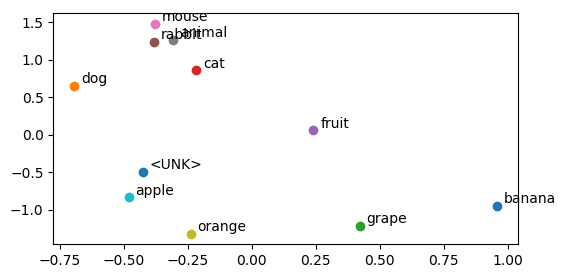

In [29]:
plt.figure(figsize=(6,3))

# loop each unique vocab
for i, word in enumerate(vocab):
    x,y = get_embed(word)
    plt.scatter(x,y)
    # plt.annotate(word, xy=(x,y), xytest =(5,2), textcoords='offset points')
    plt.annotate(word, xy = (x,y), xytext = (5,2), textcoords='offset points')
    
plt.show()
    

## 6.Cosine similarity